# Lab 2: forward and inverse geometry: writing with a pen

In this second lab, you are going to accomplish two different tasks: first, you are going to write a sentence by manually controlling the robot end effector, and if your implementation of forward geometry is correct, you will be able to reproduce what you wrote on your computer. 

Then, you will use inverse kinematics to command the robot to draw a circle 

**warning** : you will need the PD controller written in the previous lab to continue with this one. If you are using notebooks, you should extract the code either manually or using "Save as..." to create a python file you will be able to import


## Setting zero positions
First of all, we will need to properly initialise the robot. Follow the steps below to set the zero position for each motor. For more information, have a look at the description of setZero in [AROMotorControlAPI.md](./AROMotorControlAPI.md) file

- Step 1: Rotate the motors to the desired zero position, and put the aligner on the links to lock them in place.
- Step 2: call setZero(motor_id) on each motor.
- Step 3: Turn off the power supply, and wait for at least 5 seconds.
- Step 4: Turn the power supply back on, and wait for at least 5 seconds.
- Step 5: Remove the aligner

This zero position will be saved in motors' RAMs, and you will not have to recalibrate until you keep the power supply on.


In [10]:
from motor_control.AROMotorControl import AROMotorControl
mc = AROMotorControl()
mc.setZero(1)
mc.setZero(2)

motor 1 has been reset. offset: 4294607111. restart required.
motor 2 has been reset. offset: 4294940986. restart required.


True


## Forward Geometry
The robot is a delta arm with the following characteristics:

In [11]:
import numpy as np
                      #        x,y
#System size          #        /\
l1 = 0.06             #       /  \
l2 = 0.165            # l2-> /    \<-r2
r1 = 0.060            # l1 ->\_dd_/<-r1
r2 = 0.163            #  |   q1  q2
d  = 0.150 / 2        # Y|
                      #  |____>
                      #    X

Two of the joints are controlled by the motors, while the other two joints are unactuated. However, solving the forward geometry analytically is doable with a bit of trigonometry. Finding the position of the passive joints is straightforward, and from these two positions you can find the position of the effector.

In [35]:
import numpy as np
from math import sqrt, cos, sin

def get_intersections(x0, y0, r0, x1, y1, r1):
    # circle 1: (x0, y0), radius r0
    # circle 2: (x1, y1), radius r1
    d=sqrt((x1-x0)**2 + (y1-y0)**2)
    # non intersecting
    if d > r0 + r1 :
        return None
    # One circle within other
    if d < abs(r0-r1):
        return np.array([np.nan,np.nan])
    # coincident circles
    if d == 0 and r0 == r1:
        return np.array([np.nan,np.nan])
    else:
        a=(r0**2-r1**2+d**2)/(2*d)
        h=sqrt(r0**2-a**2)
        x2=x0+a*(x1-x0)/d   
        y2=y0+a*(y1-y0)/d   
        x3=x2+h*(y1-y0)/d     
        y3=y2-h*(x1-x0)/d 
        x4=x2-h*(y1-y0)/d
        y4=y2+h*(x1-x0)/d
        return (x3, y3, x4, y4)

def fg(q1, q2, positive=True):
    sign = 1 if positive else -1
    x0 = -d + l1 * -sin(q1)
    y0 =      l1 * cos(q1)
    x1 =  d + r1 * -sin(q2)
    y1 =      r1 * cos(q2)

    (x3, y3, x4, y4) = get_intersections(x0, y0, l2, x1, y1, r2)
    return np.array([x4, y4])

To test your forward geometry, write a 10-second long sequence that will read the encoders, apply forward geometry to store the positions of the effectors, and then plot them.

In [22]:
import matplotlib.pyplot as plt
import time

def read_fg_loop(mc, T=10e3):
    xs, ys = [], []
    t = time.perf_counter()
    N=int(T)
    dt = 1. / 1e3
    wait = 1. / 1e4
    for i in range(N):
        t +=dt
        # TODO: Please note that angles q1 and q2 are in degrees, and 
        # need to be converted to radians before being used with trigonometric 
        # functions that expect radian arguments.
        q1,q2 = mc.readPosition(1), mc.readPosition(2)
        xy = fg(q1, q2) 
        xs.append(xy[0])
        ys.append(xy[1])
        while(time.perf_counter()-t<dt):
            pass
            time.sleep(wait)
    plt.scatter(xs, ys, s=1)
    plt.show()

Test your implementation within a try-catch block, as you would normally do. 

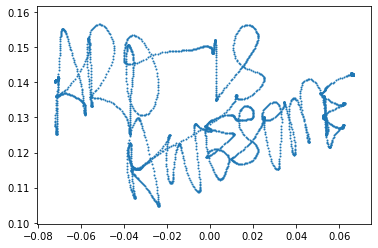

motors stopped!


In [33]:
from motor_control.AROMotorControl import AROMotorControl
try:
    mc = AROMotorControl()
    read_fg_loop(mc, T=3000)
except KeyboardInterrupt:
    print("KeyboardInterrupt received, stopping motors...")
except Exception as e:
    print(f"an error occurred: {e}")
finally:
    mc.applyCurrentToMotor(1, 0)
    mc.applyCurrentToMotor(2, 0)
    print("motors stopped!")

## Inverse geometry

Now write the IG function that will compute the inverse geometry of the robot. Use it to command the robot to draw a circle on the board


In [6]:
def ig(xy):
    '''Computes forward geometry'''
    return np.zeros(2)

def ik_serial(x,y, positive=True):
    sign = 1 if positive else -1
    l12=l1*l1
    l22=l2*l2
    x2=x*x
    y2=y*y
    q2 = sign * acos( (x2+y2-l12-l22) / (2*l1*l2) )
    q1 = atan2( y , x ) - atan2((l2 * sin(q2)) , (l1 + l2*(cos(q2))))
    return (q1,q2)

def ik_delta(xy):
    x = xy[0]
    y = xy[1]
    q1,_ = ik_serial(x-d,y,True)
    q0,_ = ik_serial(x+d,y,False)
    return np.array([q0,q1])